In [1]:
import statsmodels.stats.proportion as ssp
import itertools
import math
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import matplotlib as mplt
from adjustText import adjust_text
import statsmodels.stats.proportion
pd.options.mode.chained_assignment = None
import matplotlib.colors as colors_mplt

In [4]:
def read_model_xy(g):
    '''Return dictionary with model params and xy coordinates for given group'''
    model_params = pd.read_csv("../scripts/pgls_res/{}.model_params.tsv".format(g),sep="\t")
    xy_data = pd.read_csv("../scripts/pgls_res/{}.xy_data.tsv".format(g),sep="\t")
    return model_params, xy_data

def identity_line(ax=None, ls='--', *args, **kwargs):
    '''Draws identity line'''
    ax = ax or plt.gca()
    identity, = ax.plot([], [], ls=ls, *args, **kwargs)
    def callback(axes):
        low_x, high_x = ax.get_xlim()
        low_y, high_y = ax.get_ylim()
        low = min(low_x, low_y)
        high = max(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(ax)
    ax.callbacks.connect('xlim_changed', callback)
    ax.callbacks.connect('ylim_changed', callback)
    return ax

def plot_pgls(data, g, experiment, pgls, ax, color, scatter, alpha, line, label_legend):
    '''Plots experiment vs. X(Z)/A alpha in group g to ax,
    also returns dict with lambda, r2 and pval'''

    # Get params into dict, then get pertinent stats
    param_df = data[g]["params"]
    params = list(param_df[param_df.experiment==experiment].transpose().to_dict().values())[0]
    slope = params["{}_slope".format(pgls)]
    intercept = params["{}_intercept".format(pgls)]
    lambda_val = params["ml_lambda"]
    r2 = params["{}_rsq".format(pgls)]
    p = params["{}_pval".format(pgls)]
    
    # Get xy data
    xy_df = data[g]["xy"]
    xy = xy_df[xy_df.experiment==experiment].reset_index(drop=True)
    
    # Plot scatter and line
    label = ""
    if label_legend:
        label = "{}:\n".format(g.replace("Aves", "Birds")) + r"$\lambda={:.2f}, p={:.3f}, r^2={:.2f}$".format(lambda_val, p, r2)
    if scatter:
        ax.scatter(xy["xvar"], xy["yvar"], label=label, c=color, alpha=alpha, zorder=10)
    min_x = xy["xvar"].min()
    max_x = xy["xvar"].max()
    min_y = min_x*slope + intercept
    max_y = max_x*slope + intercept
    if line:
        ax.plot([min_x, max_x], [min_y, max_y], c=color)

    return {"lambda":lambda_val, "r2":r2, "pval":p}
    
def plot_sp_text(data, g, experiment, sp2common, selected_species, ax, colors):
    '''Annotates species names to ax'''

    # Get xy data
    xy_df = data[g]["xy"]
    xy = xy_df[xy_df.experiment==experiment].reset_index(drop=True)
    xy = xy[xy.Species.isin(selected_species)]
    texts = [ax.text(r.xvar, r.yvar, sp2common[r.Species], size=9, c=colors[i]) for i,r in xy.iterrows()]
    adjust_text(texts,arrowprops=dict(arrowstyle='-', color='salmon'))

In [5]:
data = {}
for group in ["Mammals", "Aves"]:
    model_params, xy_data = read_model_xy(group)
    data[group] = {"params":model_params,
                   "xy":xy_data}
    
# Palette
palette = pd.read_csv("./../data/plot_colors.tsv",sep="\t").set_index("Order").to_dict()["Color"]

# Species to common
sp2common = pd.read_csv("../data/latin2common_shortened.txt",sep="\t").set_index("Species").to_dict()["Common_names"]

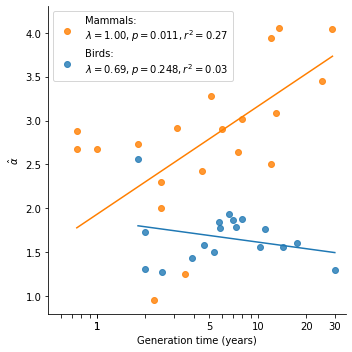

In [6]:
### G vs. X/A alpha ###
f,ax = plt.subplots(figsize=[5,5])

### Common styling ###
alpha_y_range = [0.8, 4.3]
g_x_range = [np.log10(0.5), np.log10(35)]
original_Gs = list(np.linspace(0.6,1,5)) + list(range(1,11)) + [20,30]
xlabels = ["" if g not in [1,5,10,20,30] else g for g in original_Gs]
log10_Gs = np.log10(original_Gs)

# Plot pgls and scatter
for group in ["Mammals", "Aves"]:
    plot_pgls(data, group, "GenerationLength_d", "pgls_ml", ax, palette[group], True, 0.8, True, True)
    
# X axis
ax.set_xlim(g_x_range)
ax.set_xticks(log10_Gs)
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"Generation time (years)")

# Y axis
ax.set_ylim(alpha_y_range)
ax.set_ylabel(r"$\hat{\alpha}$")
ax.legend()

sns.despine()
plt.tight_layout()
f.savefig("pdfs/Figure_3.pdf")